In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import quad

References
- [Coding MCMC: Data Science Code](https://www.youtube.com/watch?v=KmqTrm-bn8k&t=140s)
- [Accept-Reject Sampling: Data Science Concepts](https://www.youtube.com/watch?v=OXDqjdVVePY&t=498s)
- [Metropolis-Hastings tutorial](http://localhost:8888/notebooks/Documents/school/comp_stats/coding_examples/metropolis_hastings_tutorial.ipynb)
- [demo 4, computational statistic](http://localhost:8888/notebooks/Documents/school/comp_stats/week_4/demo4.ipynb)

In [2]:
# This function is the numerator of the target distribution
def f(x):
    if x >= 0:
        return np.exp(-(x-1)/2) + np.exp(-(x-1)**2)
    else: 
        return np.exp((x-1)/3) + np.exp((x-1)**3)

To make $\, f(x) \,$ a proper probability density function, we would need to divide it by its integral over its $\, x \,$ support (which is the whole real axis in this case). In other words

$$ p(x) = \frac{f(x)}{\int_{-\infty}^{\infty} f(t) \, dt} $$

would be a proper probability density function, as it would satisfy the requirements for a valid probability density function

1. $\, p(x) \ge 0 \quad \forall x \,$
2. $\, \int_{-\infty}^{\infty} p(x) \, dx = 1 \,$

Let's find the normalizing constant $\, \int_{-\infty}^{\infty} f(t) \, dt \,$ for the sake of the example. Note that in MCMC methods, we don't actually need the normalizing constant to sample from $\, p(x) \,$ (that's the magic of MCMC).

In [3]:
def norm_const():
    result, error = quad(f, -np.inf, np.inf)
    return result

In [4]:
nc = norm_const()

In [5]:
nc

7.165555860816388

In [6]:
x_vals = np.linspace(-20, 20, 1000)
fx = np.array([f(x) for x in x_vals])
px = np.array([f(x) / nc for x in x_vals])

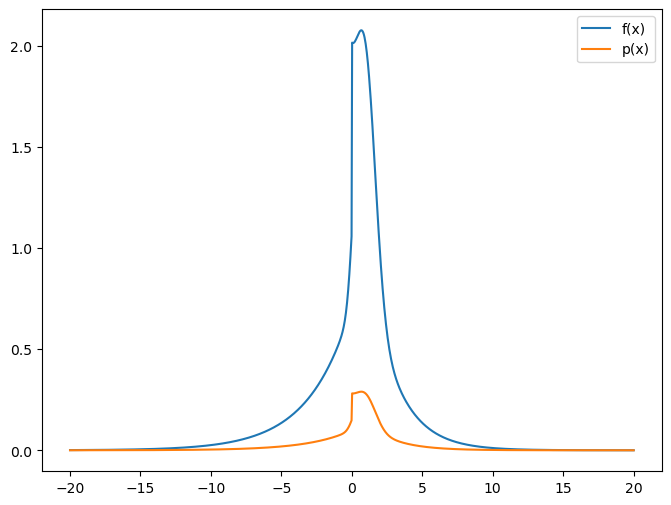

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_vals, fx, label='f(x)')
ax.plot(x_vals, px, label='p(x)')
ax.legend();

- The expected value of $\, p(x) \,$ given by any random draw is $\, \approx 0.2717289 \,$ (obtained via wolfram alpha).

<h2>Designing candidate distribution</h2>

We need to design the candidate distribution $\, g(x) \,$ such that it always lies above $\, f(x). \,$ This is done by scaling $\, g(x) \,$ by some big enough constant $\, M. \,$

<h3>Case 1: Accept-Reject sampling with $\, N(0,3) \,$ candidate distribution</h3>

Even though we decided to use $\, N(0,3) \,$ as our candidate distribution $\, g(x), \,$ we still need to find the constant $\, M \,$ that scales $\, g(x) \,$ such that $\, M g(x) \,$ is always above $\, f(x). \,$

In [8]:
def g(x, mu, sigma):
    return (1/np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x-mu)**2/(2 * sigma**2))

In [9]:
def heuristic_approach(M, mu, sigma):
    x_vals = np.linspace(-30, 30, 1000)
    fx = np.array([f(x) for x in x_vals])
    gx = np.array([g(x, mu=mu, sigma=sigma) for x in x_vals])
    for i in range(len(M)):
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x_vals, fx, label='f(x)')
        ax.plot(x_vals, M[i] * gx, label='Mg(x)')
        ax.set_title(f'M={M[i]}')
        ax.legend()

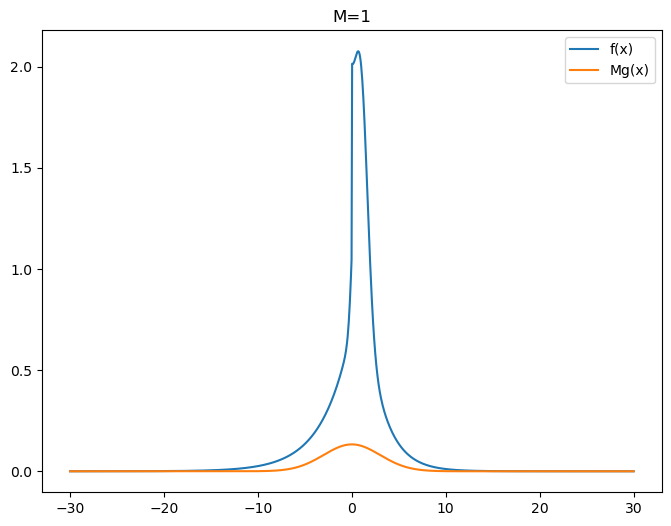

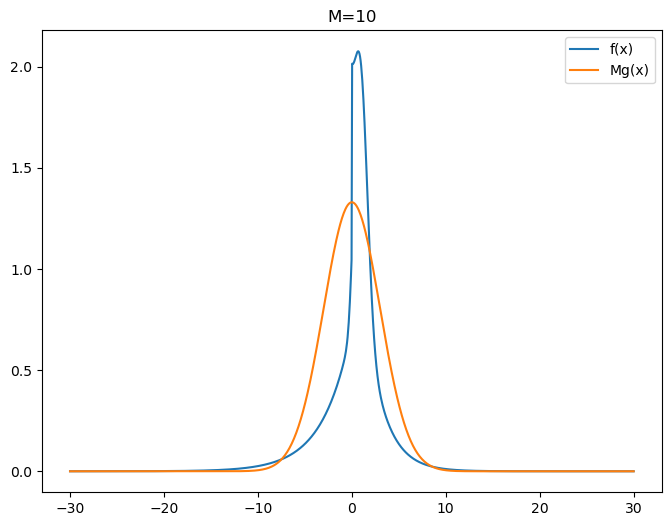

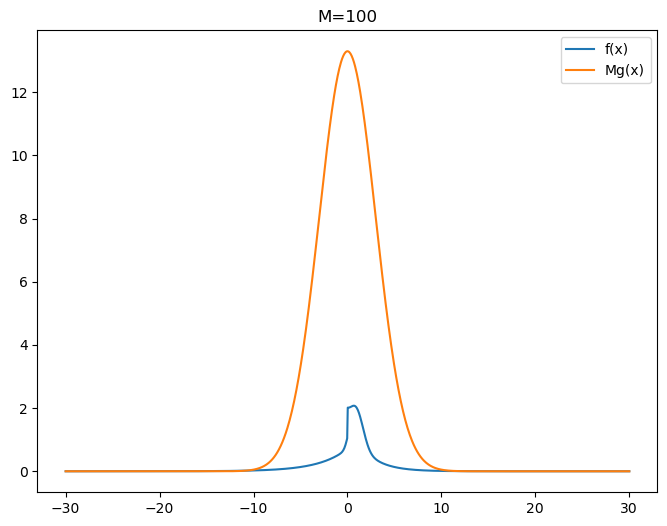

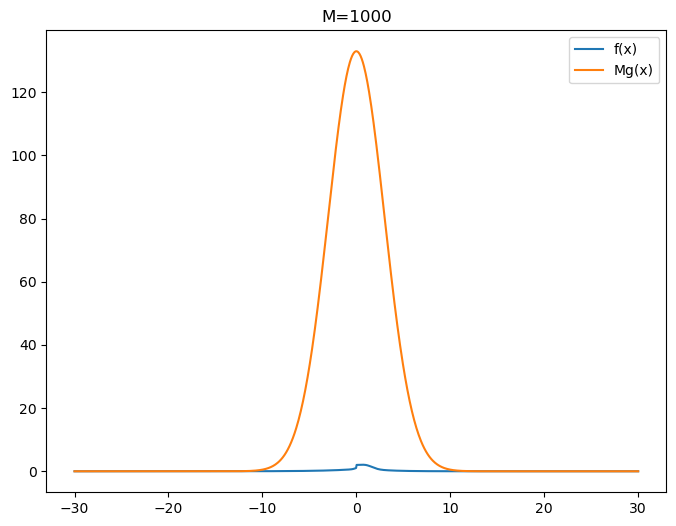

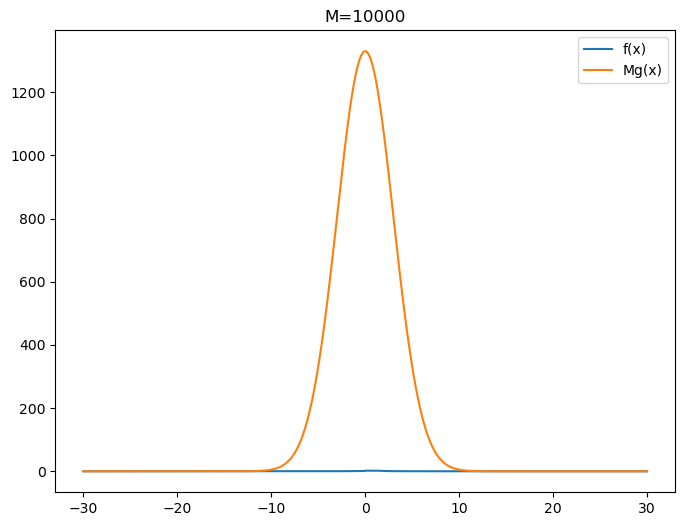

In [10]:
heuristic_approach(M=np.array([1, 10, 100, 1000, 10000]), mu=0, sigma=3)

Let's zoom in the case $\, M=1000. \,$

In [11]:
def zoom(M, mu, sigma):
    x_vals = np.linspace(-30, 30, 1000)
    fx = np.array([f(x) for x in x_vals])
    gx = np.array([g(x, mu=mu, sigma=sigma) for x in x_vals])
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x_vals, fx, label='f(x)')
    ax.plot(x_vals, M * gx, label='Mg(x)')
    ax.set_title(f'M={M}')
    ax.set_ylim(0, 0.05)
    ax.legend();

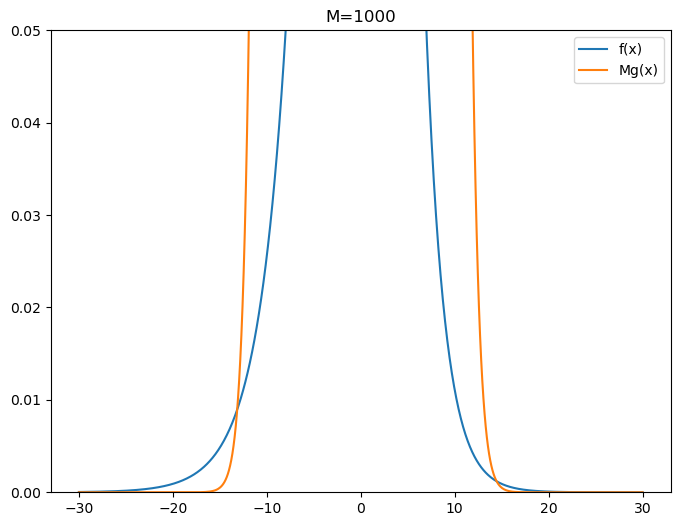

In [12]:
zoom(M=1000, mu=0, sigma=3)

- As can be seen, $\, f(x) \,$ is still above the candidate distribution in the tails when zooming really close. This is probably not a problem though, se we will use $\, M=1000. \,$

The Rejection sampling algorithm in its general form

1. Simulate $\, X' \sim g$
2. Simulate $\, U \sim \text{Uniform}(0,1)$
3. If $\, U < \large\frac{f(X')}{M g(X')}, \,$ return $\, X', \,$ else reject $\, X' \,$ (and repeat from row 1)

In [13]:
def rejection_sampling(n, M, mu, sigma):
    """
    Implement the rejection sampling algorithm.
    
    Args:
        n: number of samples that we're proposing as candidates
        (note that most of these are most likely not going to be accepted,
        so n does not represent the number of (accepted) samples generated)
    """
    samples = []
    for _ in range(n):
        X_tilde = np.random.normal(loc=mu, scale=sigma)    # Sample a candidate x value
        U = np.random.uniform(low=0.0, high=1.0)
        acceptance_prob = f(X_tilde) / (M * g(x=X_tilde, mu=mu, sigma=sigma))
        if U < acceptance_prob:
            samples.append(X_tilde)
    return np.array(samples)

In [14]:
samples_rej = rejection_sampling(n=1000000, M=1000, mu=0, sigma=3)

In [15]:
samples_rej.shape

(7133,)

- Out of 1 million draws, 7067 got accepted.

In [16]:
print(f'Efficiency (% of samples accepted): {(samples_rej.shape[0] / 1000000) * 100}')

Efficiency (% of samples accepted): 0.7132999999999999


- Approximately 0.7% of the proposed candidates got accepted.
- Efficiency is very low due to the high value of $\, M. \,$

Recall that the true expected value (obtained via wolfram alpha) of $\, p(x) \,$ is 0.27.
Let's see what is the expected value of our samples obtained via the rejection sampling.

In [17]:
np.mean(samples_rej)

np.float64(0.3177264237028904)

- Not too far, but not exactly close either.

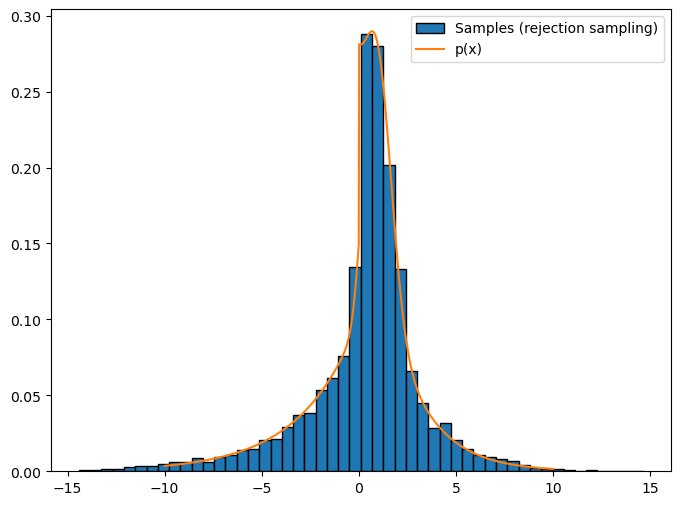

In [18]:
x_vals = np.linspace(-10, 10, 1000)
px = np.array([f(x) / nc for x in x_vals])
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(samples_rej, edgecolor='black', bins=50, density=True, label='Samples (rejection sampling)')
ax.plot(x_vals, px, label='p(x)')
ax.legend();

<h3>Case 2: Accept-reject sampling with $\, N(1,4) \,$ candidate distribution</h3>

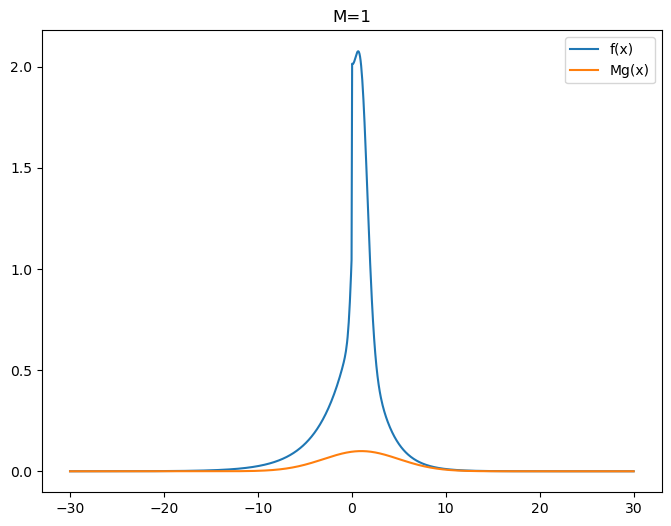

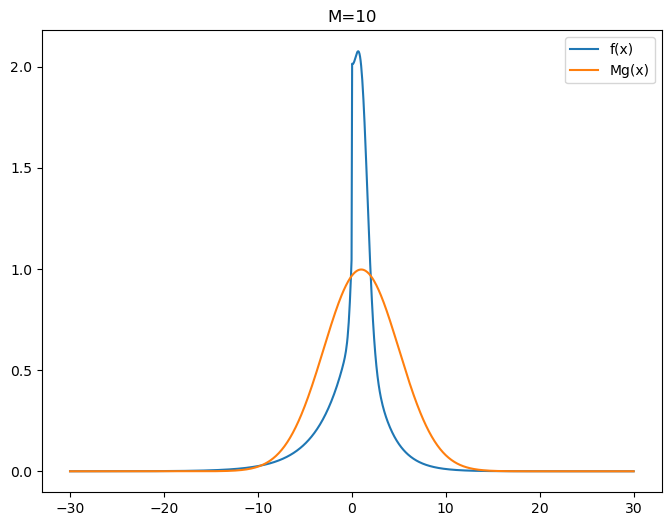

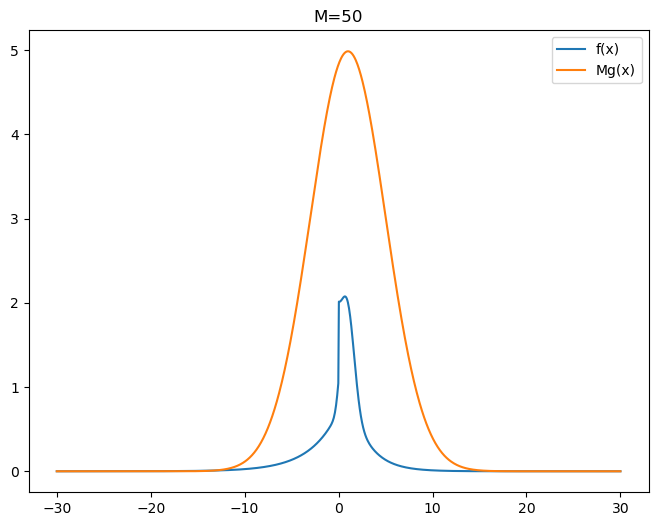

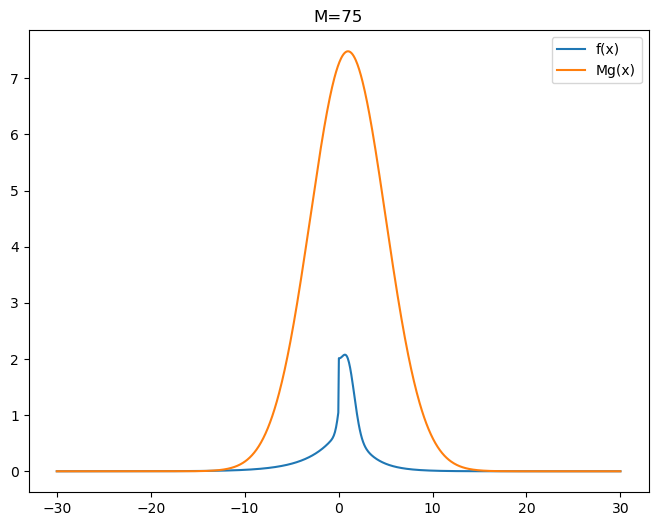

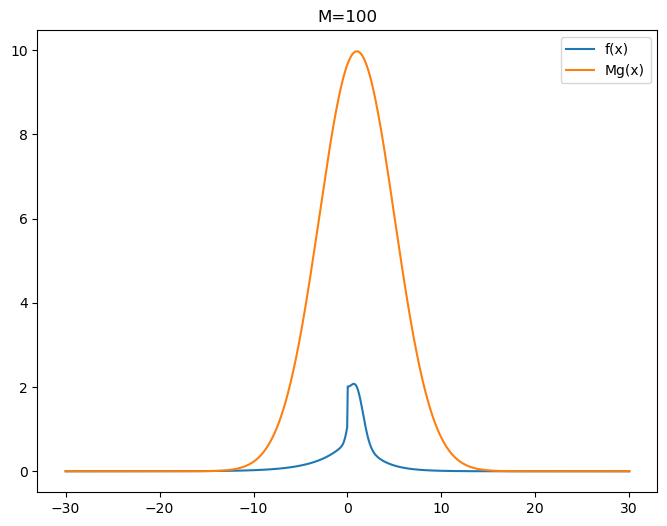

In [19]:
heuristic_approach(M=np.array([1, 10, 50, 75, 100]), mu=1, sigma=4)

- In this case, $\, M=50 \,$ seems already to be sufficient enough (recall that smaller values of $\, M \,$ will make the sampling more *efficient*).
- Let's zoom in.

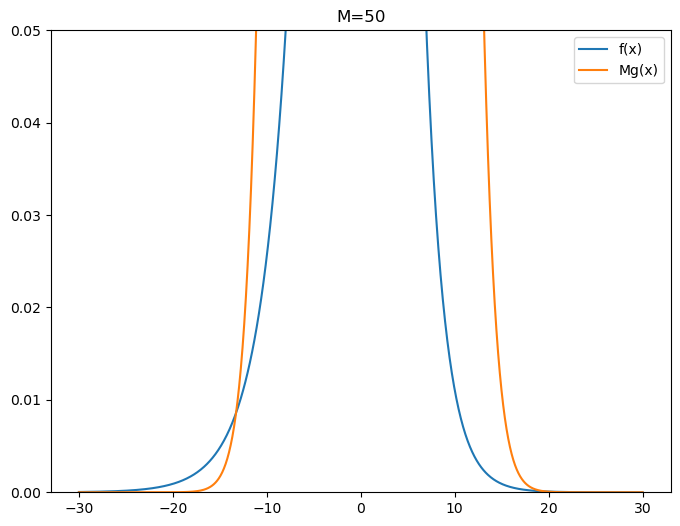

In [20]:
zoom(M=50, mu=1, sigma=4)

- Again, the tails are not under our scaled proposal distribution $\, M g(x), \,$ but this might be sufficient.
- The key observation, however, is that when using this better (i.e., more suitable) candidate distribution $\, g \sim N(1,4), \,$ we were able to obtain the same outcome (in terms of how well the candidate distribution covers the unnormalized target distribution) with $\, 20x \,$ smaller value of $\, M. \,$
- Why do we care? Well, the smaller the value of $\, M \,$ we are able to use, the more efficient the sampling is going to be (i.e., the smaller the value of $\, M, \,$ the more candidate samples are going to get accepted from some fixed value of draws).
- Let's use $\, M=50. \,$

In [21]:
samples_rej2 = rejection_sampling(n=1000000, M=50, mu=1, sigma=4)

In [22]:
print(f'Efficiency (% of samples accepted): {(samples_rej2.shape[0] / 1000000) * 100}')

Efficiency (% of samples accepted): 14.3122


In [23]:
14.2652 / 0.7291

19.565491702098477

- We notice that by changing the shape of the proposal distribution, which allowed us to make $\, M$ $\, 20x \,$ smaller, the efficiency increased a lot. 
- Efficiency with $\, N(1,4) \,$ and $\, M=50 \,$ is approx. $\, 20x \,$ greater than with $\, N(0,3) \,$ and $\, M=1000. \,$

Again, recall that the true expected value of $\, p(x) \approx 0.27 \,$ (obtained via wolfram alpha).

In [24]:
# Expected value obtained via rejection sampling, g ~ N(1,4), M=50
np.mean(samples_rej2)

np.float64(0.32478746800097835)

In [25]:
# Expected value obtained via rejection sampling, g ~ N(0,3), M=1000
np.mean(samples_rej)

np.float64(0.3177264237028904)

- We notice, however, that more efficient sampling does not necessarily mean better result, as indicated by these expected values.
- With $\, g \sim N(0,3) \,$ and $\, M=1000, \,$ the expected value is actually closer to the true expected value.
- Let's see if we increase $\, M \,$ from 50 to 100.

In [26]:
np.mean(rejection_sampling(n=1000000, M=100, mu=1, sigma=4))

np.float64(0.30234087309616814)

- Still worse than with the most inefficient approach.

In [27]:
np.mean(rejection_sampling(n=1000000, M=200, mu=1, sigma=4))

np.float64(0.27989023083778397)

- Ok so with $\, M=200 \,$ and with the more suitable candidate distribution $\, g \sim N(1,4) \,$ we got really close already.

<h3>Case 3: Metropolis algorithm with $\, N(x_{\text{previous}}, \sigma^2) \,$ candidate distribution</h3>

- Metropolis algorithm is a *Markov Chain Monte Carlo* (MCMC) method.
- In MCMC methods, the new sample depends on the **previous sample** (not two previous samples, not three previous samples, but exactly the **one previous sample**).

In [28]:
def metropolis(x, sigma=2):
    """
    Implement one step of the Metropolis algorithm.
    
    Args:
        x: the initial state of the Markov chain (x0)
        sigma: standard deviation of the proposal distribution
    """
    # Sample candidate from the proposal distribution
    x_tilde = np.random.normal(loc=x, scale=sigma)
    
    # Acceptance probability
    # (probability of accepting the current candidate)
    A = min(1, f(x_tilde) / f(x))
    
    # Simulate U ~ Uniform(0,1)
    u = np.random.uniform()
    
    # If U <= A, we accept the move (sample), 
    # otherwise we reject it (stay in the current state x)
    if u <= A:
        return x_tilde
    else:
        return 

In [29]:
def metropolis(n, x, sigma):
    """
    Implement the Metropolis algorithm.
    
    Args:
        n: number of candidate samples to propose
        x: initial state of the Markov chain (x0)
        sigma: standard deviation of the proposal distribution
    """
    # A list to store the samples
    samples = []
    
    # Initialize the Markov chain with the initial state x
    samples.append(x)
    
    # A helper variable to indicate how many samples got accepted
    # (for efficiency calculation)
    num_accept = 0
    
    for _ in range(n):
        # Sample candidate from the proposal distribution
        x_tilde = np.random.normal(loc=samples[-1], scale=sigma)
    
        # Acceptance probability
        # (probability of accepting the current candidate)
        A = min(1, f(x_tilde) / f(samples[-1]))
    
        # Simulate U ~ Uniform(0,1)
        u = np.random.uniform()
    
        # If U < A, we accept the (sample), 
        # otherwise we reject it and stay in the current state x
        if u < A:
            samples.append(x_tilde)
            num_accept += 1
        else:
            # To stay in the current state, simply add the current state to the chain again
            samples.append(samples[-1])
    
    print(f'Efficiency (% of samples accepted): {(num_accept / n) * 100}')
    return np.array(samples)

In [44]:
samples_metropolis = metropolis(n=1000000, x=1, sigma=4)

Efficiency (% of samples accepted): 46.955999999999996


Note that there is typically a burn-in phase at the beginning of a MCMC run, before the Markov chain reaches the high-density area of the target distribution $\, p(x). \,$ During this phase, the chain is still "finding its way" and may be sampling from regions that are not representative of the target distribution. To account for this, we typically remove some proportion of samples from the beginning of the chain (this is usually referred to as a burn-in phase) before using or analyzing the samples. Note that the samples after the burn-in phase are assumed to be drawn from the stationary distribution $\, \pi(x) \,$ (i.e., the distribution that the Markov chain has converged to, which is of course ideally the desired target distribution $\, p(x)).$

In [55]:
burn_in = 6000
samples_metropolis_retained = samples_metropolis[burn_in:]

Recall that the expected value of $\, p(x) \,$ is $\, \approx 0.2717289 \,$ (obtained via wolfram alpha). Let's compare the three different methods.

**Case 1:** Accept-Reject sampling with $\, N(0,3) \,$ candidate distribution

**Case 2:** Accept-reject sampling with $\, N(1,4) \,$ candidate distribution

**Case 3:** Metropolis algorithm with $\, N(x_{\text{previous}}, \sigma^2) \,$ candidate distribution

In [56]:
case1_eff = (samples_rej.shape[0] / 1000000) * 100
case2_eff = (samples_rej2.shape[0] / 1000000) * 100
case3_eff = 46.9329

case1_mean = np.mean(samples_rej)
case2_mean = np.mean(samples_rej2)
case3_mean = np.mean(samples_metropolis_retained)

print('##### True expected value #####')
print(0.2717289)
print()
print('##### Case 1 #####')
print(f'Efficiency (% of samples accepted): {case1_eff:.4f}')
print(f'Expected value: {case1_mean:.4f}')
print()
print('##### Case 2 #####')
print(f'Efficiency (% of samples accepted): {case2_eff:.4f}')
print(f'Expected value: {case2_mean:.4f}')
print()
print('##### Case 3 #####')
print(f'Efficiency (% of samples accepted): {case3_eff:.4f}')
print(f'Expected value: {case3_mean:4f}')
print()

##### True expected value #####
0.2717289

##### Case 1 #####
Efficiency (% of samples accepted): 0.7133
Expected value: 0.3177

##### Case 2 #####
Efficiency (% of samples accepted): 14.3122
Expected value: 0.3248

##### Case 3 #####
Efficiency (% of samples accepted): 46.9329
Expected value: 0.269671



Case 3 (MCMC) wins by far.

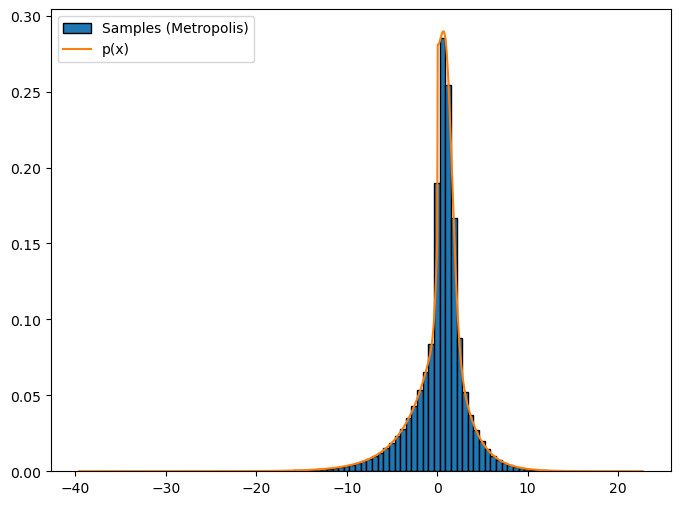

In [58]:
x_vals = np.linspace(np.min(samples_metropolis_retained), np.max(samples_metropolis_retained), 1000)
px = np.array([f(x) / nc for x in x_vals])
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(samples_metropolis_retained, edgecolor='black', bins=100, density=True, label='Samples (Metropolis)')
ax.plot(x_vals, px, label='p(x)')
ax.legend(loc='upper left');